In [1]:
import glob

import pandas as pd
import awkward as ak
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
pz = lambda particle: particle.pt * np.sinh(particle.eta)
px = lambda particle: particle.pt * np.cos(particle.phi)
py = lambda particle: particle.pt * np.sin(particle.phi)

def get_mtt(array):
    # visible lepton sums
    vis_leptons = ak.concatenate([array.Electron, array.Muon, array.Tau], axis=1)[:, [0, 1]]

    vis_px1, vis_px2 = px(vis_leptons[:, 0]), px(vis_leptons[:, 1])
    vis_py1, vis_py2 = py(vis_leptons[:, 0]), py(vis_leptons[:, 1])
    vis_pz1, vis_pz2 = pz(vis_leptons[:, 0]), pz(vis_leptons[:, 1])
    
    vis_p1 = (vis_px1**2 + vis_py1**2 + vis_pz1**2)**0.5
    vis_p2 = (vis_px2**2 + vis_py2**2 + vis_pz2**2)**0.5
    
    vis_e1 = (vis_px1**2 + vis_py1**2 + vis_pz1**2 + vis_leptons[:, 0].mass**2)**0.5
    vis_e2 = (vis_px2**2 + vis_py2**2 + vis_pz2**2 + vis_leptons[:, 1].mass**2)**0.5

    # gen neutrinos
    nu_px = ak.sum(array.tau_nus.x, axis=1)
    nu_py = ak.sum(array.tau_nus.y, axis=1)
    nu_pz = ak.sum(array.tau_nus.z, axis=1)
    nu_e = (nu_px**2 + nu_py**2 + nu_pz**2)**0.5

    # regressed neutrinos
    reg_px = array.tautauNN_regression_output[:, 0] + array.tautauNN_regression_output[:, 3]
    reg_py = array.tautauNN_regression_output[:, 1] + array.tautauNN_regression_output[:, 4]
    reg_pz = array.tautauNN_regression_output[:, 2] + array.tautauNN_regression_output[:, 5]
    reg_e = (reg_px**2 + reg_py**2 + reg_pz**2)**0.5

    # vis + gen nu
    m_tt_gen = (
        (vis_e1 + vis_e2 + nu_e)**2 -
        (vis_px1 + vis_px2 + nu_px)**2 - 
        (vis_py1 + vis_py2 + nu_py)**2 - 
        (vis_pz1 + vis_pz2 + nu_pz)**2
    )**0.5
    
    # vis + reg nu
    m_tt_reg = (
        (vis_e1 + vis_e2 + reg_e)**2 -
        (vis_px1 + vis_px2 + reg_px)**2 - 
        (vis_py1 + vis_py2 + reg_py)**2 - 
        (vis_pz1 + vis_pz2 + reg_pz)**2
    )**0.5

    return m_tt_gen, m_tt_reg

In [3]:
PATTERN = "/nfs/dust/cms/user/yamralim/cf_cache/hbt_store/analysis_hbt/cf.UniteColumns/run2_2017_nano_uhh_v11/{}/nominal/calib__none/sel__default/prod__z_fractions/dev3_allz/data_*.parquet"

dfs = []

z_cols = ["z_gen_pos", "z_gen_neg", "z_rec_neg", "z_rec_pos", "dm_neg", "dm_pos"]
mtt_cols = ["Tau", "Electron", "Muon", "tau_nus", "tautauNN_regression_output"]

for process_name, df_name in [
    ("dy_lep_m50_amcatnlo", "dy"),
    ("tt_dl_powheg", "tt"),
    ("hh_ggf_bbtautau_madgraph", "hh"),
]:
    #print(f"checking {process_name}")
    for path in glob.glob(PATTERN.format(process_name)):
        #print(f"reading {path}")
        data = ak.from_parquet(path, columns=z_cols + mtt_cols + ["category_ids"])
        mtt_gen, mtt_reg = get_mtt(data)
        df = ak.to_dataframe(data[z_cols])
        df["mtt_gen"] = mtt_gen
        df["mtt_reg"] = mtt_reg
        df["process"] = df_name
        dfs.append(df)
df = pd.concat(dfs)

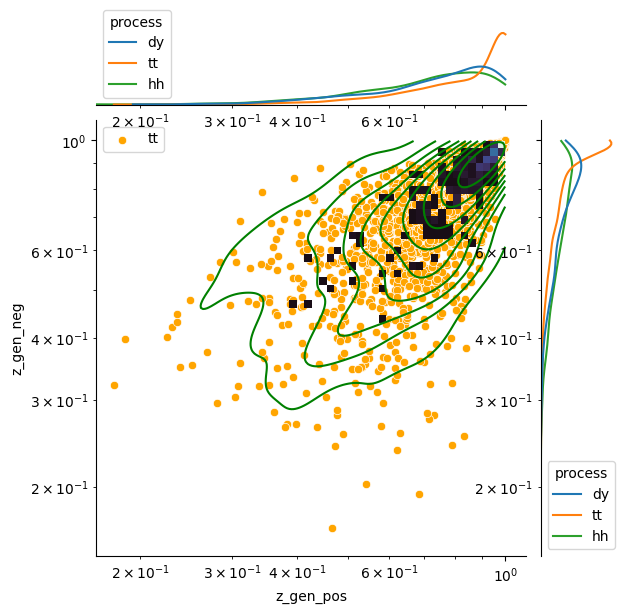

In [4]:
# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Create the joint plot
g = sns.JointGrid(
    data=filtered_df,
    x="z_gen_pos",
    y="z_gen_neg",
    hue="process",
)

# Scatter plot for tt
sns.scatterplot(
 data=filtered_df[filtered_df["process"] == "tt"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="tt",
    color="orange"
)

# KDE plot for hh
sns.kdeplot(
    data=filtered_df[filtered_df["process"] == "hh"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="hh",
    fill=False,
    log_scale=True,
    color="green",
    cut=0
)

# Hist plot for dy
sns.histplot(
    data=filtered_df[filtered_df["process"] == "dy"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="dy",
    bins=50,
    pthresh=.1,
    cmap="mako"
)

# Marginal KDE plots
sns.kdeplot(
    data=filtered_df,
    x="z_gen_pos",
    hue="process",
    ax=g.ax_marg_x,
    common_norm=False,
    log_scale=True,
    cut=0
)
sns.kdeplot(
    data=filtered_df,
    y="z_gen_neg",
    hue="process",
    ax=g.ax_marg_y,
    common_norm=False,
    log_scale=True,
    cut=0
)

# Add legend
g.ax_joint.legend()

# Adjust the legend position
sns.move_legend(g.ax_joint, "upper left")

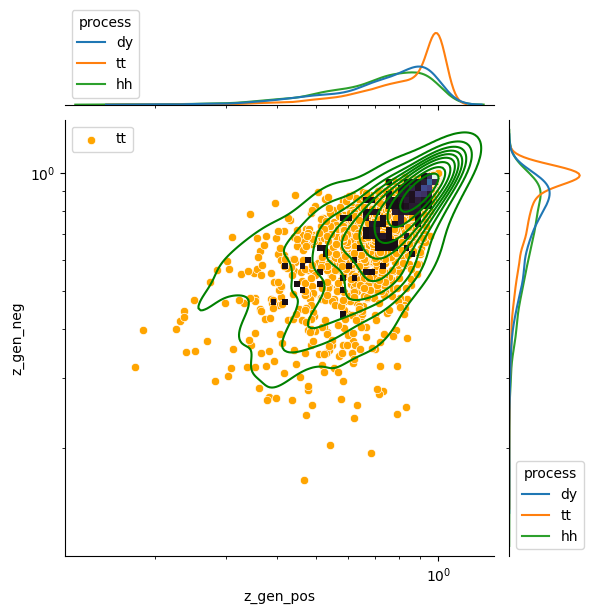

In [5]:
# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Create the joint plot
g = sns.JointGrid(
    data=filtered_df,
    x="z_gen_pos",
    y="z_gen_neg",
    hue="process",
)

# Scatter plot for tt
sns.scatterplot(
 data=filtered_df[filtered_df["process"] == "tt"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="tt",
    color="orange"
)

# KDE plot for hh
sns.kdeplot(
    data=filtered_df[filtered_df["process"] == "hh"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="hh",
    fill=False,
    log_scale=True,
    color="green"
)

# Hist plot for dy
sns.histplot(
    data=filtered_df[filtered_df["process"] == "dy"],
    x="z_gen_pos",
    y="z_gen_neg",
    ax=g.ax_joint,
    label="dy",
    bins=50,
    pthresh=.1,
    cmap="mako"
)

# Marginal KDE plots
sns.kdeplot(
    data=filtered_df,
    x="z_gen_pos",
    hue="process",
    ax=g.ax_marg_x,
    common_norm=False,
    log_scale=True
)
sns.kdeplot(
    data=filtered_df,
    y="z_gen_neg",
    hue="process",
    ax=g.ax_marg_y,
    common_norm=False,
    log_scale=True
)

# Add legend
g.ax_joint.legend()

# Adjust the legend position
sns.move_legend(g.ax_joint, "upper left")

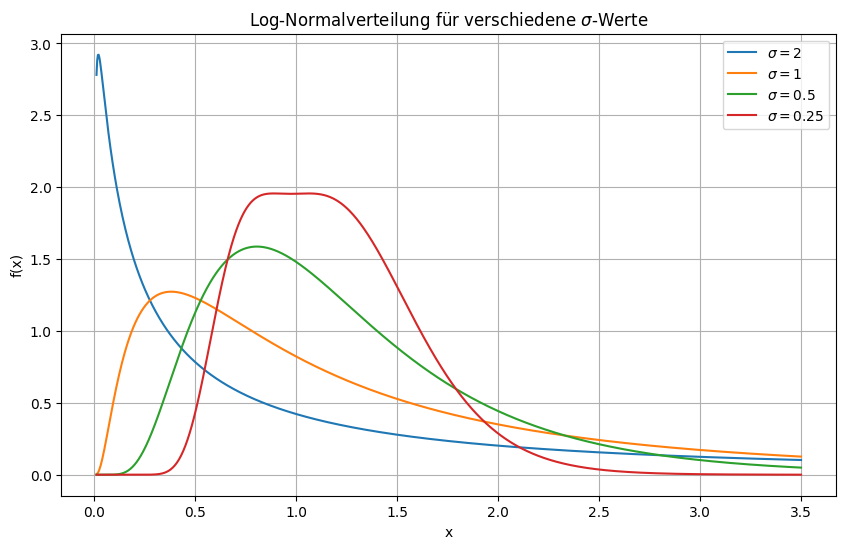

In [4]:
# Log-Normalverteilungsfunktion
def log_normal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))
def kde(x, mu, sigma):
    return log_normal(x*0.75, mu, sigma) + log_normal(x*1.25, mu, sigma)

# Werte für mu und verschiedene sigma
mu = 0
sigma_values = [2, 1, 0.5, 0.25]

# Bereich für x-Werte von 0.01 bis 1 (außer 0, da ln(0) nicht definiert ist)
x = np.linspace(0.01, 3.5, 1000)

# Plot erstellen
plt.figure(figsize=(10, 6))

for sigma in sigma_values:
    y = kde(x, mu, sigma)
    plt.plot(x, y, label=f'$\sigma={sigma}$')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Log-Normalverteilung für verschiedene $\sigma$-Werte')
plt.legend()
plt.grid(True)
plt.show()

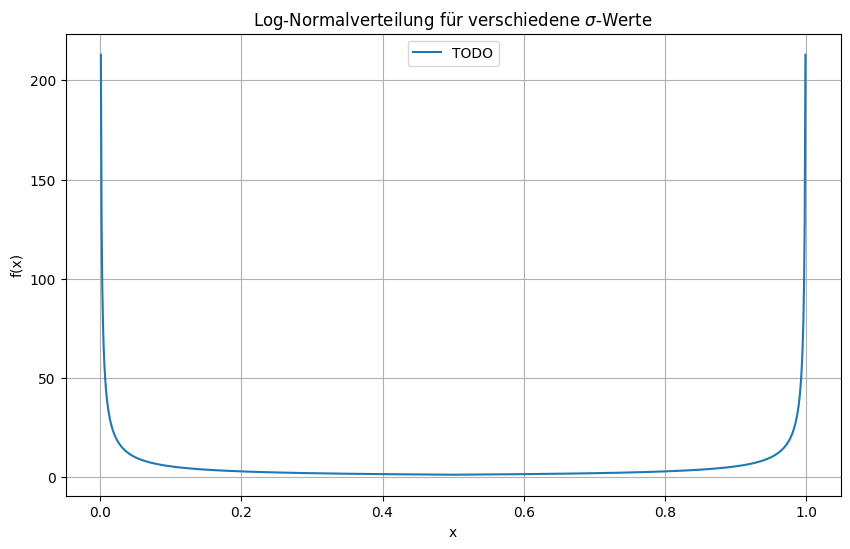

In [5]:
# Log-Normalverteilungsfunktion
def log_normal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

def get_sigma(mu):
    return 5

def kde(x):
    z_values = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75]  # will be a long list
    result = np.empty(len(x), dtype=np.float32)
    left = x <= 0.5
    result[left] = sum(log_normal(x[left], z, get_sigma(z)) for z in z_values)
    result[~left] = sum(log_normal(1 - x[~left], z, get_sigma(z)) for z in z_values)
    return result

# Bereich für x-Werte von 0.01 bis 1 (außer 0, da ln(0) nicht definiert ist)
x = np.linspace(0, 1, 1000)

# Plot erstellen
plt.figure(figsize=(10, 6))

plt.plot(x, kde(x), label=f'TODO')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Log-Normalverteilung für verschiedene $\sigma$-Werte')
plt.legend()
plt.grid(True)
plt.show()

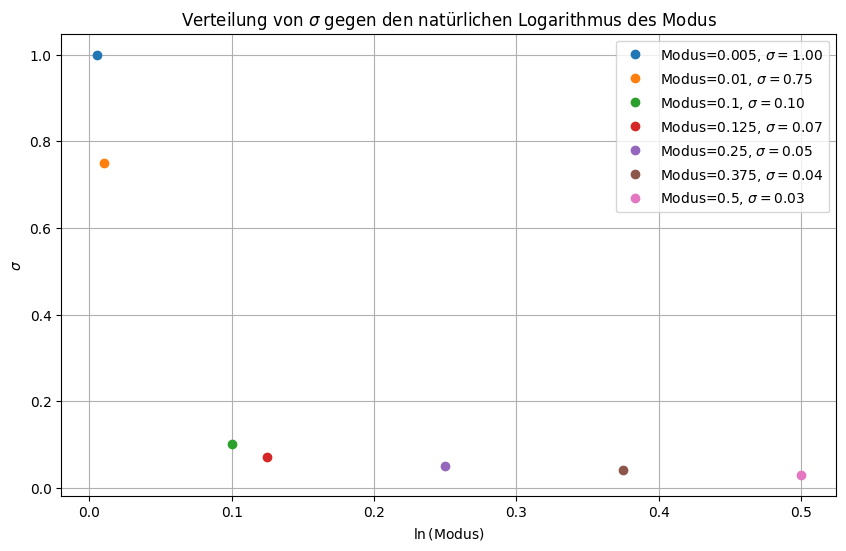

In [6]:
# Log-Normalverteilungsfunktion
def log_normal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

# Berechne mu aus dem Modus und sigma
def calculate_mu(modus, sigma):
    return np.log(modus) + sigma**2

# Werte für Modus und Sigma
modus_values = [0.005, 0.01, 0.1, 0.125, 0.25, 0.375, 0.5]
sigma_values = [1.0, 0.75, 0.1, 0.07, 0.05, 0.04, 0.03]

# Bereich für x-Werte von 0.01 bis 3.5 (außer 0, da ln(0) nicht definiert ist)


# Plot erstellen
plt.figure(figsize=(10, 6))

for modus, sigma in zip(modus_values, sigma_values):
    mu = calculate_mu(modus, sigma)
    y = sigma
    plt.plot(modus, y, 'o', label=f'Modus={modus}, $\\sigma={sigma:.2f}$')

plt.xlabel('$\\ln$(Modus)')
plt.ylabel('$\\sigma$')
plt.title('Verteilung von $\\sigma$ gegen den natürlichen Logarithmus des Modus')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
!pip install scipy


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 171.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


0.01671513800492873 -0.7880525635296838


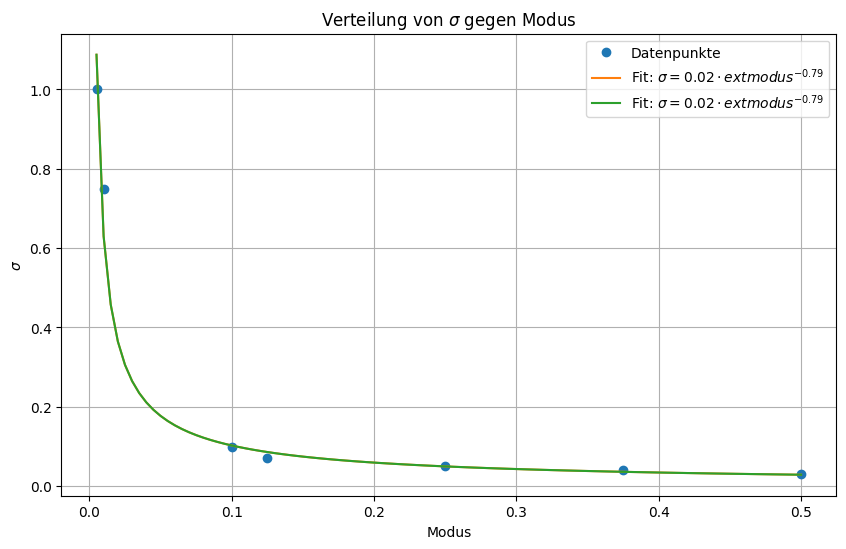

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Log-Normalverteilungsfunktion
def log_normal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

# Berechne mu aus dem Modus und sigma
def calculate_mu(modus, sigma):
    return np.log(modus) + sigma**2

# Werte für Modus und Sigma
modus_values = np.array([0.005, 0.01, 0.1, 0.125, 0.25, 0.375, 0.5])
sigma_values = np.array([1.0, 0.75, 0.1, 0.07, 0.05, 0.04, 0.03])

# Potenzfunktion für die Kurvenanpassung
def power_function(modus, a, b):
    return a * modus**b

# Logarithmische Anpassung für die Potenzfunktion durchführen
log_modus_values = np.log(modus_values)
log_sigma_values = np.log(sigma_values)
coefficients = np.polyfit(log_modus_values, log_sigma_values, 1)
b, log_a = coefficients
a = np.exp(log_a)

# Fit-Kurve berechnen
fit_sigma_values = power_function(modus_values, a, b)

# Plot erstellen
plt.figure(figsize=(10, 6))

# Datenpunkte plotten
plt.plot(modus_values, sigma_values, 'o', label='Datenpunkte')

# Fit-Kurve plotten
x_fit = np.linspace(min(modus_values), max(modus_values), 100)
y_fit = power_function(x_fit, a, b)
print (a,b) 
plt.plot(x_fit, y_fit, '-', label=f'Fit: $\\sigma = {a:.2f} \cdot \text{{modus}}^{{{b:.2f}}}$')
y_2 = a*np.exp(np.log(x_fit)* b)
plt.plot(x_fit, y_2, '-', label=f'Fit: $\\sigma = {a:.2f} \cdot \text{{modus}}^{{{b:.2f}}}$')
plt.xlabel('Modus')
plt.ylabel('$\\sigma$')
plt.title('Verteilung von $\\sigma$ gegen Modus')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

# Example DataFrame setup (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Poisson distribution function
def poisson_continuous(x, lam):
    return lam**x * np.exp(-lam) / np.array([np.math.gamma(xi + 1) for xi in x])

# Function to calculate lambda from z (logarithmic relationship)
def lambda_func(z):
    return np.log(1 + 9 * z)  # Logarithmic relationship scaled to [1, 10]

# Function to calculate the PDF values using Poisson distribution and KDE
def poisson_kde_pdf(z_vals, x):
    kde = gaussian_kde(z_vals, bw_method=0.01)  # Kernel density estimation with bandwidth
    kde_values = kde.evaluate(x)
    y = np.zeros_like(x)
    for i, xi in enumerate(x):
        lam = lambda_func(xi)
        y += kde_values[i] * poisson_continuous(x, lam)
    y /= np.trapz(y, x)  # Normalize by the integral of the PDF
    return y

# Function to plot the Poisson PDF using KDE for better structure
def plot_poisson_kde(z_vals, x):
    y = poisson_kde_pdf(z_vals, x)
    plt.plot(x, y, label=f'Poisson KDE for {len(z_vals)} values')

# Range for x values from 0 to 1 with higher resolution
x = np.linspace(0.0, 1.0, 5000)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Poisson distribution for filtered data using KDE
plot_poisson_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Continuous Poisson Distribution with KDE for Different z Values')
plt.legend()
plt.grid(True)
plt.show()


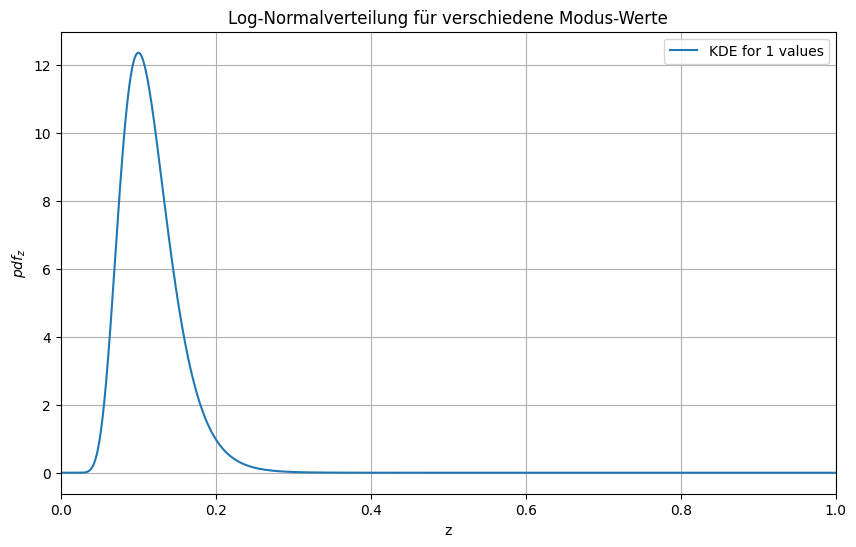

In [18]:
# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)


# Log-Normalverteilungsfunktion
def log_normal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

# Berechne mu aus dem Modus und sigma
def calculate_mu(modus, sigma):
    return np.log(modus) + sigma**2

# Werte für modus und sigma
#modus = 0.01
# sigma_values = [0.1, 0.25, 0.5, 0.75]
#sigma_values = [0.75]

# Bereich für x-Werte von 0.01 bis 3.5 (außer 0, da ln(0) nicht definiert ist)
x = np.linspace(0.0, 1.0, 1000)

# Plot erstellen
plt.figure(figsize=(10, 6))

if 0:
    mu = calculate_mu(modus=0.005, sigma=1.0)
    y = log_normal(x, mu, sigma=1.0)
    plt.plot(x, y, label=f'Modus={0.005}, $\sigma={1.0:.2f}$')
    
    mu = calculate_mu(modus=0.01, sigma=0.75)
    y = log_normal(x, mu, sigma=0.75)
    plt.plot(x, y, label=f'Modus={0.01}, $\sigma={0.75:.2f}$')
    
    # central pdf
    mid_sigma = 0.05
    mu = calculate_mu(modus=0.25, sigma=mid_sigma)
    y = log_normal(x, mu, mid_sigma)
    plt.plot(x, y, label=f'Modus={0.25}, $\sigma={mid_sigma:.2f}$')
    
    central_sigma = 0.03
    mu = calculate_mu(modus=0.5, sigma=central_sigma)
    y = log_normal(x, mu, central_sigma)
    plt.plot(x, y, label=f'Modus={0.5}, $\sigma={central_sigma:.2f}$')


def sigma_func(z):
    a, b = 0.01671513800492873, -0.7880525635296838
    return a * z**b *3

#def mu_sigma_func(z):
#    sigma = sigma_func(z)
#    mu = np.log(z) + sigma**2
#    return mu, sigma

#def plot_pdf(z, x):
#    mu, sigma = mu_sigma_func(z if z <= 0.5 else (1 - z))
#    y = log_normal(x if z <= 0.5 else (1 - x), mu, sigma)
#    plt.plot(x, y, label=f'z={z:.3f}, $\sigma={sigma:.4f}$')

#plot_pdf(0.05, x)
#plot_pdf(0.5, x)
#plot_pdf(0.499, x)
#plot_pdf(0.95, x)

def kde(z_vals):
    def func(x):
       values = []
        for z in z_vals:
            if z <= 0.5:
                sigma = sigma_func(z)
                mu = np.log(z) + sigma**2
                values.append(log_normal(x, mu, sigma))
            else:
                sigma = sigma_func(1 - z)
                mu = np.log(1 - z) + sigma**2
                vals = log_normal(-(x - (1 - z)) + z, mu, sigma)
                values.append(vals)
        return sum(values)
    return func

def plot_kde(z_vals, x):
    y = kde(z_vals)(x)
    plt.plot(x, y, label=f'KDE for {len(z_vals)} values')

# plot_kde([*(30 * [0.00001]), 0.1, 0.2, 0.3, 0.34, 0.35, 0.7, 0.9, 0.9, 0.95, 0.998, 1.0], x)
#plot_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)
#plot_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)
plot_kde([0.1], x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Log-Normalverteilung für verschiedene Modus-Werte')
plt.legend()
plt.grid(True)
plt.show()

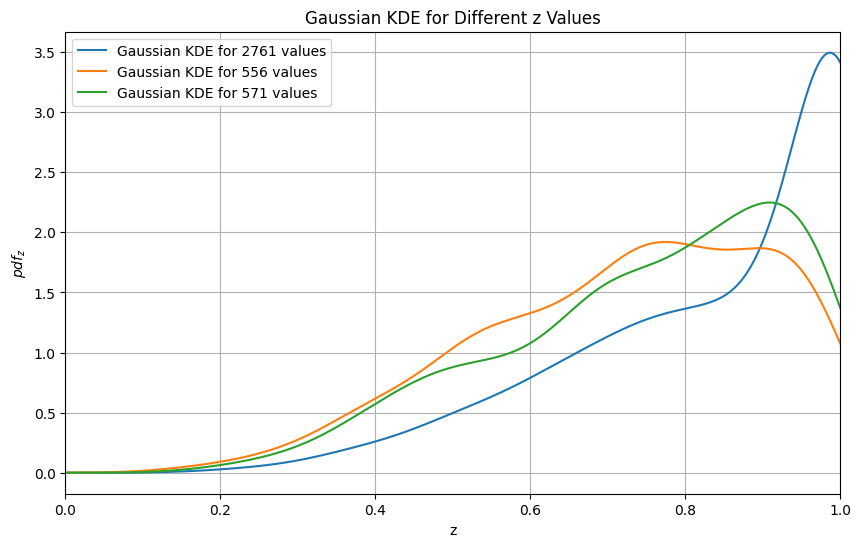

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde, norm

# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Function to calculate the PDF values using Gaussian distribution
def gaussian_pdf(z_vals, x):
    kde = gaussian_kde(z_vals, bw_method=0.3)  # Kernel density estimation with bandwidth
    pdf = kde.evaluate(x)
    return pdf

# Function to plot the Gaussian PDF using KDE for better structure
def plot_gaussian_kde(z_vals, x):
    y = gaussian_pdf(z_vals, x)
    plt.plot(x, y, label=f'Gaussian KDE for {len(z_vals)} values')

# Range for x values from 0 to 1
x = np.linspace(0.0, 1.0, 1000)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Gaussian KDE for filtered data
plot_gaussian_kde(filtered_df[filtered_df["process"] == "tt"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Gaussian KDE for Different z Values')
plt.legend()
plt.grid(True)
plt.show()


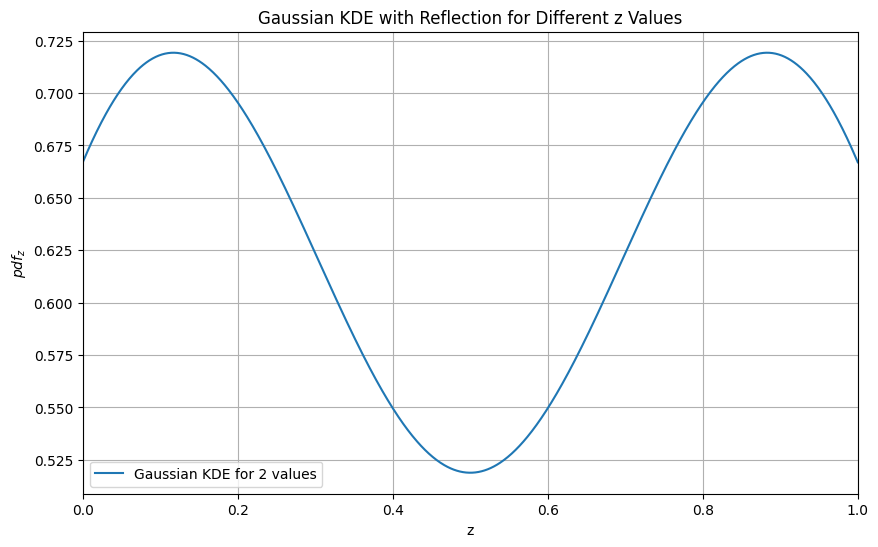

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

# Example DataFrame setup (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Filter the main data
filtered_df = df[(df["dm_pos"] == 10) & (df["dm_neg"] == 1)]

# Normalize the data to the range of [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Function to calculate the PDF values using Gaussian KDE and handle out-of-bounds reflection
def gaussian_kde_pdf(z_vals, x):
    kde = gaussian_kde(z_vals, bw_method=0.5)  # Kernel density estimation with bandwidth
    pdf = kde.evaluate(x)
    
    # Reflect the out-of-bounds parts back into the range [0, 1]
    pdf += kde.evaluate(2 - x) * (x > 1)  # Reflect values greater than 1
    pdf += kde.evaluate(-x) * (x < 0)  # Reflect values less than 0
    
    return pdf

# Function to plot the Gaussian KDE with out-of-bounds reflection
def plot_gaussian_kde(z_vals, x):
    y = gaussian_kde_pdf(z_vals, x)
    plt.plot(x, y, label=f'Gaussian KDE for {len(z_vals)} values')

# Range for x values from 0 to 1
x = np.linspace(0.0, 1.0, 1000)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Gaussian KDE for filtered data
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "tt"]["z_gen_pos"].tolist(), x)
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), x)
#plot_gaussian_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)
plot_gaussian_kde([0.1, 0.9], x)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Gaussian KDE with Reflection for Different z Values')
plt.legend()
plt.grid(True)
plt.show()


24.499932648204787


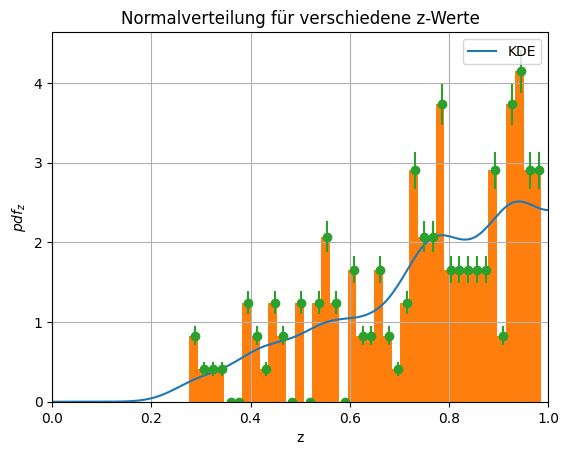

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

# Beispielhafte Erstellung eines DataFrames (falls nicht vorhanden)
# df = pd.read_csv('your_data.csv')  # Beispiel zum Laden Ihrer Daten

# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 11)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

# Bereich für x-Werte von 0 bis 1
x = np.linspace(0, 1, 1000)

mu = 0.1  # Beispielwert für den Mittelwert
sigma = 0.1
# Berechnung der PDF der Normalverteilung
pdf = norm.pdf(x, mu, sigma)



# KDE-Funktion basierend auf der Normalverteilung
def kde(z_vals, sigma=0.1, flip_threshold=0.001):
    mu_flip_left = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_right = 1 - mu_flip_left
    def func(x):
        values = []
        for z in z_vals:
            mu = z  # Mittelwert ist der jeweilige z-Wert
            # define up to three pdfs
            pdfs = []
            # central gauss
            pdfs.append(partial(norm.pdf, loc=mu, scale=sigma))
            # optional left tail if cut off integral is below 0.001
            if mu < mu_flip_left:
                pdfs.append(partial(norm.pdf, loc=-mu, scale=sigma))
            # right tail
            if mu > mu_flip_right:
                pdfs.append(partial(norm.pdf, loc=2 - mu, scale=sigma))

            # evaluate and fill
            values.extend([pdf(x) for pdf in pdfs])
        return sum(values) / len(z_vals)
    return func

# Plot der KDE
def plot_kde(x, *args, **kwargs):
    k = kde(*args, **kwargs)
    y = k(x)
    plt.plot(x, y, label=f'KDE')
    return k

# Beispiele für KDE Plots
#plot_kde(x, z_vals=[0.1, 0.9], sigma=0.05 )
k = plot_kde(x, z_vals=filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist(), sigma=0.05)
#plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist(), density=True, bins=40)
counts, bins, _= plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist(), density=True, bins=40)
errors = np.sqrt(counts/np.sum(counts))
plt.errorbar(bins[:-1]+ 0.0125, counts, yerr=errors, fmt='o')
chi = 1/ 40 * sum([((counts[i] -k(0.0125+i*0.025))/ errors[i])**2 for i in range(40) if counts[i]])
print(chi)
#plot_kde(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), x)
#plt.plot(x, norm.pdf(x, loc=0.1, scale=0.05))
#plt.plot(x, norm.pdf(x, loc=0.9, scale=0.05))
#plt.yscale("log")
plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Normalverteilung für verschiedene z-Werte')
plt.legend()
plt.grid(True)
plt.show()


5.743299748923732


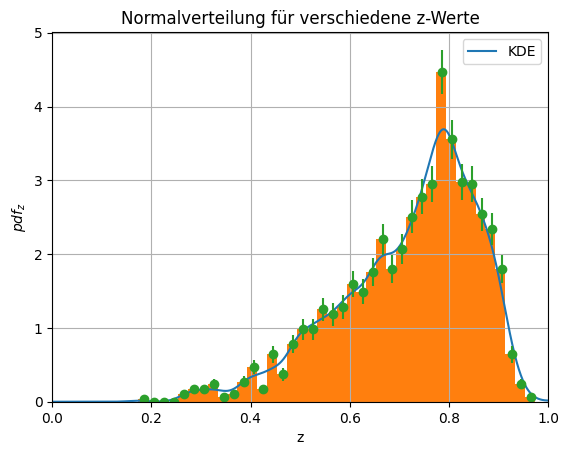

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

# Bereich für x-Werte von 0 bis 1
x = np.linspace(0, 1, 1000)

# KDE-Funktion basierend auf der Normalverteilung
def kde(z_vals, sigma=0.1, flip_threshold=0.001):
    mu_flip_left = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_right = 1 - mu_flip_left
    def func(x):
        values = []
        for z in z_vals:
            mu = z  # Mittelwert ist der jeweilige z-Wert
            # define up to three pdfs
            pdfs = []
            # central gauss
            pdfs.append(partial(norm.pdf, loc=mu, scale=sigma))
            # optional left tail if cut off integral is below 0.001
            if mu < mu_flip_left:
                pdfs.append(partial(norm.pdf, loc=-mu, scale=sigma))
            # right tail
            if mu > mu_flip_right:
                pdfs.append(partial(norm.pdf, loc=2 - mu, scale=sigma))

            # evaluate and fill
            values.extend([pdf(x) for pdf in pdfs])
        return sum(values) / len(z_vals)
    return func

# Plot der KDE
def plot_kde(x, *args, **kwargs):
    k = kde(*args, **kwargs)
    y = k(x)
    plt.plot(x, y, label=f'KDE')
    return k

# Beispiele für KDE Plots
k = plot_kde(x, z_vals=filtered_df[filtered_df["process"] == "hh"]["z_rec_pos"].tolist(), sigma=0.02)
counts, bins, _ = plt.hist(filtered_df[filtered_df["process"] == "hh"]["z_rec_pos"].tolist(), density=True, bins=40)
errors = np.sqrt(counts / np.sum(counts))
plt.errorbar(bins[:-1] + 0.0125, counts, yerr=errors, fmt='o')
chi = 1 / 40 * sum([((counts[i] - k(0.0125 + i * 0.025)) / errors[i]) ** 2 for i in range(40) if counts[i]])
print(chi)

plt.xlim((0, 1))
plt.xlabel('z')
plt.ylabel('$pdf_{z}$')
plt.title('Normalverteilung für verschiedene z-Werte')
plt.legend()
plt.grid(True)
plt.show()


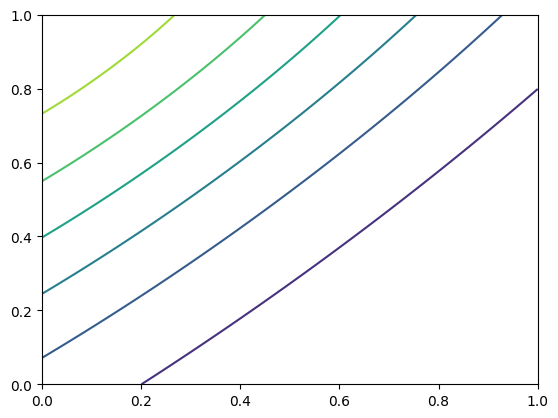

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats import multivariate_normal


N    = 200
X    = np.linspace(0, 1, N)
Y    = np.linspace(0, 1, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv   = multivariate_normal([0, 1], [[1, 0.8], [0.8, 1]])
Z    = rv.pdf(pos)

plt.contour(X, Y, Z)
plt.show()

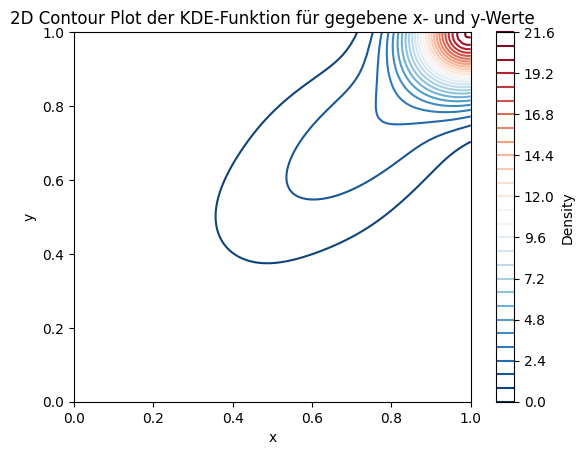

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 1)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "tt"]["z_gen_neg"].tolist(), 
                 filtered_df[filtered_df["process"] == "tt"]["z_gen_pos"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.01, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
plt.contour(X, Y, Z, levels=30, cmap="RdBu_r")
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Contour Plot der KDE-Funktion für gegebene x- und y-Werte')
plt.show()

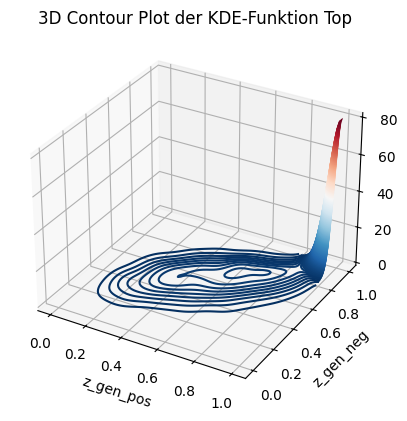

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[
(df["dm_pos"] == 0)
#((df["dm_pos"] == 11) | (df["dm_pos"] == 10))
& 
(df["dm_neg"] == -1)
#((df["dm_neg"] == 11) | (df["dm_neg"] == 10))
]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "dy"]["z_gen_pos"].tolist(), 
                 filtered_df[filtered_df["process"] == "dy"]["z_gen_neg"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.003, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
ax = plt.figure().add_subplot(projection='3d')
ax.contour(X, Y, Z, levels=500, cmap="RdBu_r")
#ax.colorbar(label='Density')
plt.xlabel('z_gen_pos')
plt.ylabel('z_gen_neg')
plt.title('3D Contour Plot der KDE-Funktion Top')
plt.show()

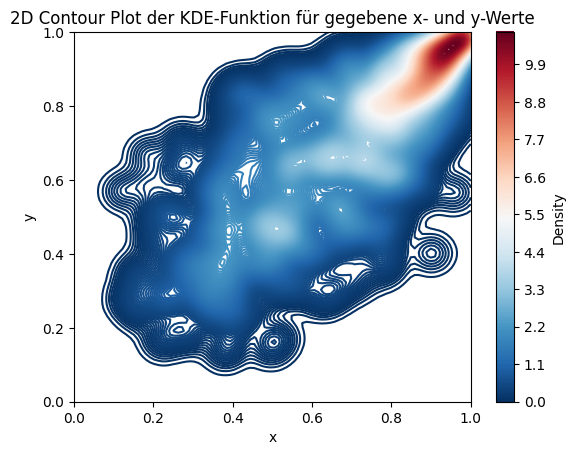

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 1)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_gen_pos"] = filtered_df["z_gen_pos"].clip(0, 1)
filtered_df["z_gen_neg"] = filtered_df["z_gen_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "hh"]["z_gen_neg"].tolist(), 
                 filtered_df[filtered_df["process"] == "hh"]["z_gen_pos"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.001, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
plt.contour(X, Y, Z, levels=500, cmap="RdBu_r")
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Contour Plot der KDE-Funktion für gegebene x- und y-Werte')
plt.show()

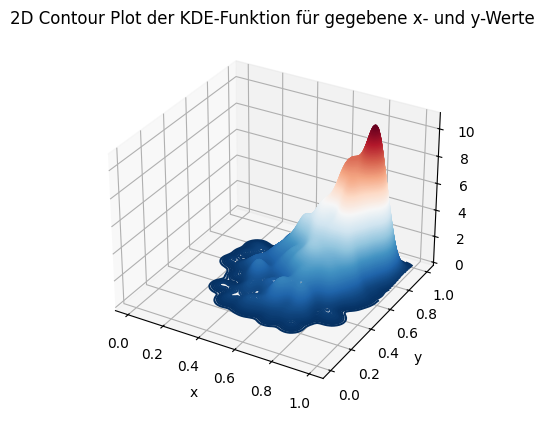

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from functools import partial
# Filtern der Hauptdaten
filtered_df = df[(df["dm_pos"] == 0) & (df["dm_neg"] == 1)]

# Normieren der Daten auf den Bereich von [0, 1]
filtered_df["z_rec_pos"] = filtered_df["z_rec_pos"].clip(0, 1)
filtered_df["z_rec_neg"] = filtered_df["z_rec_neg"].clip(0, 1)

z_vals = list(zip(filtered_df[filtered_df["process"] == "hh"]["z_rec_neg"].tolist(), 
                 filtered_df[filtered_df["process"] == "hh"]["z_rec_pos"].tolist()))
#z_vals = np.array([[0.1, 0.15], [0.5, 0.4], [0.75, 0.3], [0.85, 0.9], [0.05, 0.95]])
# Gitter von x und y
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def kde(z_vals, sigma=0.001, flip_threshold=0.01):
    mu_flip_low = -norm.ppf(flip_threshold, loc=0, scale=sigma)
    mu_flip_high = 1 - mu_flip_low
    # print("thresholds for flip:", mu_flip_low, mu_flip_high)

    # determine pdfs
    pdfs = []
    for zx, zy in z_vals:
        # central pdf
        multi_norm = lambda zx, zy: multivariate_normal([zx, zy], [[sigma, 0], [0, sigma]])
        pdfs.append(multi_norm(zx, zy).pdf)
        # optional left tail if cut off integral is below 0.001
        if zx <= mu_flip_low:
            pdfs.append(multi_norm(-zx, zy).pdf)
        # right tail
        if zx >= mu_flip_high:
            pdfs.append(multi_norm(2 - zx, zy).pdf)
        # bottom tail
        if zy <= mu_flip_low:
            pdfs.append(multi_norm(zx, -zy).pdf)
        # top tail
        if zy >= mu_flip_high:
            pdfs.append(multi_norm(zx, 2 - zy).pdf)
    
    def func(vals):
        return sum(pdf(vals) for pdf in pdfs) / len(z_vals)
    
    return func

# Funktion zur Berechnung der KDE-Werte auf einem Gitter
def calculate_kde_grid(z_vals, vals):
    kde_func = kde(z_vals)
    return kde_func(vals)

# Berechnung der KDE-Werte auf dem Gitter
Z = calculate_kde_grid(z_vals, np.dstack((X, Y)))
#shape = np.dstack((X, Y))
#print(shape)
# Erstelle den Contour-Plot
ax = plt.figure().add_subplot(projection='3d')
ax.contour(X, Y, Z, levels=500, cmap="RdBu_r")
#plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Contour Plot der KDE-Funktion für gegebene x- und y-Werte')
plt.show()